In [1]:
import pandas as pd

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
# cargar datos de las rutas
rutas = gpd.read_file('datos/concesionado_ruta_shp/Concesionado_Ruta.shp')
rutas.head()

,SISTEMA,RUTA,RAMAL,DETALLE,geometry
0,TRANSPORTE PÚBLICO CONCESIONADO DE RUTA,14,TENORIOS - METRO CONSTITUCIÓN,NaN,MULTILINESTRING Z ((-99.02053 19.33196 0.00000...
1,TRANSPORTE PÚBLICO CONCESIONADO DE RUTA,14,PALMITAS - METRO CONSTITUCIÓN,NaN,MULTILINESTRING Z ((-99.02342 19.33128 0.00000...
2,TRANSPORTE PÚBLICO CONCESIONADO DE RUTA,117,SAN BARTOLO - METRO ZAPATA,NaN,MULTILINESTRING Z ((-99.16456 19.37109 0.00000...
3,TRANSPORTE PÚBLICO CONCESIONADO DE RUTA,117,METRO BARRANCA DEL MUERTO - SANTA ROSA XOCHIAC...,NaN,MULTILINESTRING Z ((-99.19021 19.36159 0.00000...
4,TRANSPORTE PÚBLICO CONCESIONADO DE RUTA,43,METRO VIVEROS - RIO DE GUADALUPE,NaN,MULTILINESTRING Z ((-99.17530 19.35425 0.00000...


In [4]:
# cargar gps de las unidades
df = pd.read_csv("datos/GPS_ruta_27feb-5marz_2023.csv")
df.head()

,timestamp,id_unidad,ruta,latitud,longitud,velocidad,contadorpasajeros,tipounidad
0,2023-02-27 00:00:00,0360XHY,RUTA 36,19.310211,-99.127530,0,0,MICROBUS (MENOR A 7.5 M DE LONGITUD)
1,2023-02-27 00:00:00,0870TXP,RUTA 87,19.268187,-99.200800,0,0,AUTOBUS CORTO (ENTRE 7.5 Y 10 M DE LONGITUD)
2,2023-02-27 00:00:00,0890XXK,RUTA 89,19.653275,-99.264360,0,0,AUTOBUS CORTO (ENTRE 7.5 Y 10 M DE LONGITUD)
3,2023-02-27 00:00:00,0140EMX,RUTA 14,19.348303,-99.082010,0,0,MICROBUS (MENOR A 7.5 M DE LONGITUD)
4,2023-02-27 00:00:00,0430XTA,RUTA 43,19.329426,-99.253105,0,0,AUTOBUS CORTO (ENTRE 7.5 Y 10 M DE LONGITUD)


In [5]:
# filtrar para ruta 1
ruta_1_ramales=rutas[rutas['RUTA']=="1"]
ruta_1_gps=df[df['ruta']=="RUTA 1"]

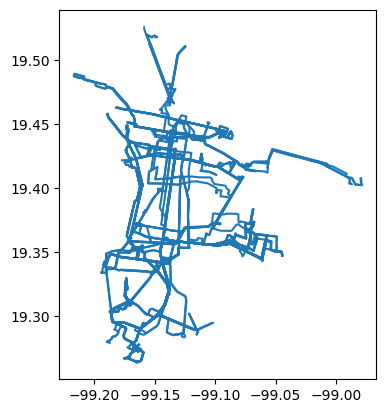

In [6]:
ruta_1_ramales.plot()
plt.show()

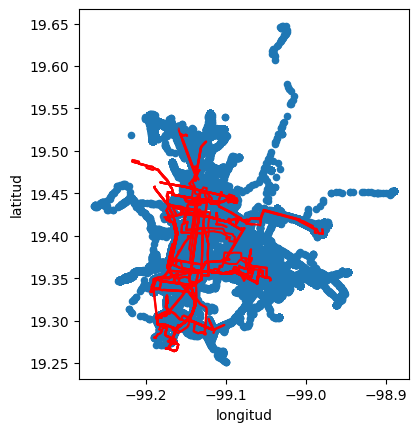

In [7]:
# datos ruta 1 (rojo) con gps (azul)
ruta_1_gps = ruta_1_gps[ruta_1_gps['longitud'] >= -99.4]
ruta_1_gps.plot(kind='scatter', x='longitud', y='latitud', ax=plt.gca())
ruta_1_ramales.plot(color='red', ax=plt.gca())


plt.show()

In [8]:
ruta_1_gps["timestamp"] = pd.to_datetime(ruta_1_gps["timestamp"])
ruta_1_gps["dia"] = ruta_1_gps["timestamp"].dt.day

In [9]:
# crear trayectorias (polilineas) por unidad / por día
from shapely.geometry import LineString

gdf = gpd.GeoDataFrame(ruta_1_gps, geometry=gpd.points_from_xy(ruta_1_gps.longitud, ruta_1_gps.latitud))

lineas_generadas_ruta_1 = gpd.GeoDataFrame(columns=['id_unidad', 'dia', 'geometry'])

for (id_unidad, dia), grupo in gdf.groupby(['id_unidad', 'dia']):
    if len(grupo) > 1:
        linea = LineString(grupo.geometry.values)
        lineas_generadas_ruta_1.loc[len(lineas_generadas_ruta_1)] = {'id_unidad': id_unidad, 'dia': dia, 'geometry': linea}


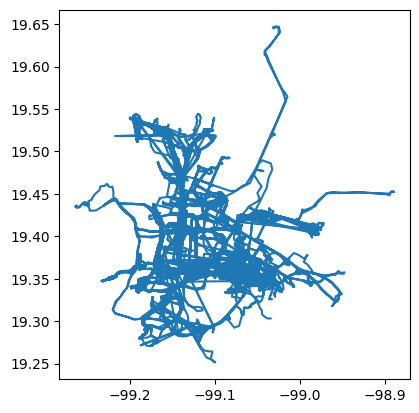

In [10]:
lineas_generadas_ruta_1.plot()
plt.show()

In [13]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

# Calcular matriz de distancias hausdorff entre cada par de trayectorias

def calcular_distancia(i, j, geom_i, geom_j):
    if i != j:
        return geom_i.simplify(tolerance=0.1).hausdorff_distance(geom_j.simplify(tolerance=0.1))
    else:
        return 0

# Paso 1: Calcular la matriz de distancia
num_lineas = len(lineas_generadas_ruta_1)
dist_matrix = np.zeros((num_lineas, num_lineas))

# Crear una lista de todos los pares de índices
all_pairs = [(i, j, lineas_generadas_ruta_1.geometry[i], lineas_generadas_ruta_1.geometry[j]) for i in range(num_lineas) for j in range(num_lineas)]

results = Parallel(n_jobs=-1)(delayed(calcular_distancia)(i, j, geom_i, geom_j) 
                              for i, j, geom_i, geom_j in tqdm(all_pairs, desc="Calculando distancias"))

# Llenar la matriz de distancia con los resultados
for idx, res in enumerate(results):
    i = idx // num_lineas
    j = idx % num_lineas
    dist_matrix[i, j] = res

Calculando distancias: 100%|██████████| 734449/734449 [14:05<00:00, 868.79it/s]  


In [23]:
from sklearn.cluster import AgglomerativeClustering

# Agrupar trayectorias similares (con distancias bajas)
cluster = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='complete', distance_threshold=0.09)
lineas_generadas_ruta_1['cluster_id'] = cluster.fit_predict(dist_matrix)

c:\Users\samue\anaconda3\envs\adip\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [24]:
lineas_generadas_ruta_1["cluster_id"].unique()

array([ 4,  7, 18, 10,  6, 17,  2,  5,  1, 14, 22,  9,  3, 11, 16, 15, 12,
       13, 19,  0,  8, 20, 21], dtype=int64)

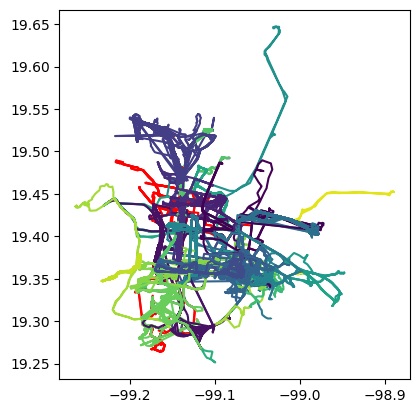

In [25]:
#imprimir agrupamientos de trayectorias
fig, ax = plt.subplots()

ruta_1_ramales.plot(color="red",ax=ax)
lineas_generadas_ruta_1.plot(column='cluster_id', ax=ax)

plt.show()

In [26]:
lineas_generadas_ruta_1.groupby("cluster_id").count().sort_values(by="id_unidad",ascending=False).head(8)

,id_unidad,dia,geometry
cluster_id,,,
7,303,303,303
4,131,131,131
18,101,101,101
5,53,53,53
10,46,46,46
3,41,41,41
2,40,40,40
8,25,25,25


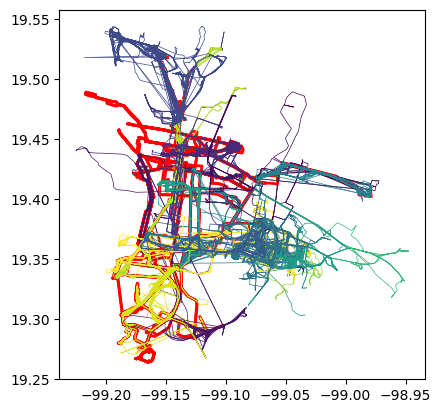

In [27]:
# Imprimir trayectorias de los clusters más grandes
cluster_counts = lineas_generadas_ruta_1['cluster_id'].value_counts()
clusters_to_plot = cluster_counts[cluster_counts >= 5].index

filtered_data = lineas_generadas_ruta_1[lineas_generadas_ruta_1['cluster_id'].isin(clusters_to_plot)]

fig, ax = plt.subplots()
ruta_1_ramales.plot(color="red", linewidth=2,ax=ax)
filtered_data.plot(column='cluster_id',linewidth=.5, ax=ax)
plt.show()


In [20]:
# exportar trayectorias y matriz de distancias
lineas_generadas_ruta_1.to_csv("datos/out/lineas_generadas_clusterizadas_ruta_1.csv")
pd.DataFrame(dist_matrix).to_csv("datos/out/matriz_distancias_ruta_1.csv")